In [38]:
# Install dependencies if not already installed
!pip install hmmlearn

Defaulting to user installation because normal site-packages is not writeable


# FPT Stock Prediction - Advanced Grid Search & Regime Switching

**Role**: Senior Quantitative Developer & AI Researcher  
**Objective**: Maximize Leaderboard Score (Minimize MSE on Raw Price)  
**Architecture**: Monolithic, Modular, OOP-based  

## Key Features
- **Robust Grid Search**: Iterates over Models, HMM Regimes, and Sequence Lengths.
- **Regime Switching**: Uses GaussianHMM to detect market regimes (Volatility, Trend).
- **RevIN**: Reversible Instance Normalization to handle distribution shift.
- **Models**: Linear, DLinear, Transformer, LSTM w/ Attention.
- **Safety Nets**: Error logging, Data Starvation checks, Fallback mechanisms.
- **Ensemble**: Automatically averages Top 3 best performing models.

In [ ]:
import os
import sys
import random
import logging
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from datetime import timedelta
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from hmmlearn.hmm import GaussianHMM

# Configuration & Setup
warnings.filterwarnings('ignore')
logging.basicConfig(filename='training_log.txt', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

Using device: cuda


## 1. Configuration & Constants

In [40]:
class Config:
    DATA_PATH = 'data/FPT_train.csv'
    SUBMISSION_DIR = 'submissions'
    PRED_LEN = 100
    TARGET_COL = 'close'
    
    # Grid Search Space
    MODELS = ['Univariate_Linear', 'Multivariate_DLinear']
    SEQ_LENS = [7, 15, 30, 60, 120, 480]
    USE_HMM_OPTIONS = [False, True]
    N_REGIMES_OPTIONS = [3, 4]
    REGIME_WINDOWS = [30, 60]
    
    # Training Hyperparams
    BATCH_SIZE = 32
    EPOCHS = 1000  # Can be increased
    PATIENCE = 15
    LEARNING_RATE = 1e-3
    
    os.makedirs(SUBMISSION_DIR, exist_ok=True)

## 2. Data Manager

In [41]:
class DataManager:
    def __init__(self, file_path):
        self.df = pd.read_csv(file_path)
        self.df['time'] = pd.to_datetime(self.df['time'])
        self.df = self.df.sort_values('time').reset_index(drop=True)
        self.preprocess()
        
    def preprocess(self):
        # Log Transform
        for col in ['open', 'high', 'low', 'close', 'volume']:
            self.df[f'{col}_log'] = np.log1p(self.df[col])
            
        # Feature Engineering
        self.df['HL_Spread'] = self.df['high_log'] - self.df['low_log']
        self.df['OC_Spread'] = self.df['close_log'] - self.df['open_log']
        
        # Returns & Volatility for HMM
        self.df['returns'] = self.df['close'].pct_change().fillna(0)
        self.df['volatility'] = self.df['returns'].rolling(window=10).std().fillna(0)
        self.df['trend'] = self.df['close'].rolling(window=10).mean().pct_change().fillna(0)
        
    def get_data(self):
        return self.df
    
    def inverse_transform(self, log_data):
        return np.expm1(log_data)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_sliding_window(data, seq_len, pred_len, target_col_idx, feature_cols_idx):
    X, y = [], []
    for i in range(len(data) - seq_len - pred_len + 1):
        X.append(data[i : i + seq_len, feature_cols_idx])
        y.append(data[i + seq_len : i + seq_len + pred_len, target_col_idx])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

## 3. Regime Detector (HMM)

In [42]:
class RegimeDetector:
    def __init__(self, n_components=3, window=30):
        self.n_components = n_components
        self.window = window
        self.model = GaussianHMM(n_components=n_components, covariance_type="full", n_iter=100, random_state=42)
        
    def fit_predict(self, df):
        # Use Returns, Volatility, Trend for regime detection
        features = df[['returns', 'volatility', 'trend']].iloc[self.window:].values
        # Standardize features for HMM
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        
        self.model.fit(features_scaled)
        states = self.model.predict(features_scaled)
        
        # Pad initial window
        full_states = np.concatenate([np.zeros(self.window) - 1, states])
        return full_states

In [43]:
class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True):
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self._init_params()

    def _init_params(self):
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        return x

# --- Models ---

class Univariate_Linear(nn.Module):
    def __init__(self, seq_len, pred_len, num_features):
        super().__init__()
        # Note: Univariate doesn't strictly need RevIN on features since input is 1D, 
        # but we keep it for consistency if we pass full features. 
        # Assuming input x is [Batch, Seq, Feat], target at idx 0.
        self.revin = RevIN(num_features)
        self.linear = nn.Linear(seq_len, pred_len)
        
    def forward(self, x):
        x = self.revin(x, 'norm')
        # Grab stats for target (index 0) before slicing
        target_mean = self.revin.mean[:, :, 0] # [Batch, 1]
        target_stdev = self.revin.stdev[:, :, 0] # [Batch, 1]
        
        x_in = x[:, :, 0] # [Batch, Seq]
        out = self.linear(x_in) # [Batch, Pred]
        
        # Denormalize manually for target
        out = out * target_stdev + target_mean
        return out

class Multivariate_DLinear(nn.Module):
    def __init__(self, seq_len, pred_len, num_features):
        super().__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.revin = RevIN(num_features)
        
        # Decomposition
        kernel_size = 25
        self.moving_avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        
        self.linear_trend = nn.Linear(seq_len * num_features, pred_len)
        self.linear_seasonal = nn.Linear(seq_len * num_features, pred_len)

    def forward(self, x):
        x = self.revin(x, 'norm')
        
        # Store stats for denorm later (Target index 0)
        target_mean = self.revin.mean[:, :, 0]
        target_stdev = self.revin.stdev[:, :, 0]
        
        # Trend
        # x shape: [Batch, Seq, Feat] -> [Batch, Feat, Seq] for AvgPool
        trend = self.moving_avg(x.permute(0, 2, 1)).permute(0, 2, 1)
        seasonal = x - trend
        
        # Flatten
        trend_flat = trend.reshape(trend.shape[0], -1)
        seasonal_flat = seasonal.reshape(seasonal.shape[0], -1)
        
        trend_out = self.linear_trend(trend_flat)
        seasonal_out = self.linear_seasonal(seasonal_flat)
        
        x_out = trend_out + seasonal_out
        
        # DENORMALIZE OUTPUT
        x_out = x_out * target_stdev + target_mean
        return x_out

class Hybrid_Transformer(nn.Module):
    def __init__(self, seq_len, pred_len, num_features):
        super().__init__()
        self.revin = RevIN(num_features)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=num_features, nhead=1, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.linear = nn.Linear(seq_len * num_features, pred_len)

    def forward(self, x):
        x = self.revin(x, 'norm')
        
        # Store stats
        target_mean = self.revin.mean[:, :, 0]
        target_stdev = self.revin.stdev[:, :, 0]
        
        x = self.transformer_encoder(x)
        x = x.reshape(x.shape[0], -1)
        x = self.linear(x)
        
        # DENORMALIZE OUTPUT
        x = x * target_stdev + target_mean
        return x

class LSTM_Attention(nn.Module):
    def __init__(self, seq_len, pred_len, num_features):
        super().__init__()
        self.revin = RevIN(num_features)
        self.lstm = nn.LSTM(num_features, 64, batch_first=True)
        self.attention = nn.Linear(64, 1)
        self.linear = nn.Linear(64, pred_len)

    def forward(self, x):
        x = self.revin(x, 'norm')
        
        # Store stats
        target_mean = self.revin.mean[:, :, 0]
        target_stdev = self.revin.stdev[:, :, 0]
        
        lstm_out, _ = self.lstm(x)
        
        # Attention Mechanism
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(lstm_out * attn_weights, dim=1)
        
        x = self.linear(context)
        
        # DENORMALIZE OUTPUT
        x = x * target_stdev + target_mean
        return x
    
class ModelFactory:
    @staticmethod
    def create_model(model_name, seq_len, pred_len, num_features):
        if model_name == 'Univariate_Linear':
            return Univariate_Linear(seq_len, pred_len, num_features)
        elif model_name == 'Multivariate_DLinear':
            return Multivariate_DLinear(seq_len, pred_len, num_features)
        elif model_name == 'Hybrid_Transformer':
            return Hybrid_Transformer(seq_len, pred_len, num_features)
        elif model_name == 'LSTM_Attention':
            return LSTM_Attention(seq_len, pred_len, num_features)
        else:
            raise ValueError(f"Unknown model: {model_name}")

## 5. Trainer & Evaluator

In [44]:
class Trainer:
    def __init__(self, model, criterion, optimizer, scheduler, patience=10):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.patience = patience
        self.best_loss = float('inf')
        self.best_state = None
        self.counter = 0
        
    def fit(self, train_loader, val_loader, epochs):
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                self.optimizer.zero_grad()
                output = self.model(X_batch)
                loss = self.criterion(output, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            
            val_loss = self.evaluate(val_loader)
            self.scheduler.step(val_loss)
            
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.best_state = deepcopy(self.model.state_dict())
                self.counter = 0
            else:
                self.counter += 1
                
            if self.counter >= self.patience:
                # print(f"Early stopping at epoch {epoch}")
                break
                
        if self.best_state:
            self.model.load_state_dict(self.best_state)
            
    def evaluate(self, loader):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = self.model(X_batch)
                loss = self.criterion(output, y_batch)
                total_loss += loss.item()
        return total_loss / len(loader)

## 6. Main Pipeline (Grid Search)

In [45]:
class Pipeline:
    def __init__(self):
        self.dm = DataManager(Config.DATA_PATH)
        self.df = self.dm.get_data()
        self.results = []
        
    def run(self):
        feature_cols = ['close_log', 'volume_log', 'HL_Spread', 'OC_Spread']
        target_col_idx = self.df.columns.get_loc('close_log')
        feature_cols_idx = [self.df.columns.get_loc(c) for c in feature_cols]
        
        total_combinations = len(Config.MODELS) * len(Config.SEQ_LENS) * len(Config.USE_HMM_OPTIONS)
        pbar = tqdm(total=total_combinations, desc="Grid Search")
        
        for model_name in Config.MODELS:
            for seq_len in Config.SEQ_LENS:
                for use_hmm in Config.USE_HMM_OPTIONS:
                    
                    if seq_len >= 120 and use_hmm:
                        pbar.update(1)
                        continue
                        
                    hmm_configs = [(None, None)]
                    if use_hmm:
                        hmm_configs = [(n, w) for n in Config.N_REGIMES_OPTIONS for w in Config.REGIME_WINDOWS]
                        
                    for n_regimes, regime_window in hmm_configs:
                        try:
                            seed_everything(42)
                            self.execute_config(model_name, seq_len, use_hmm, n_regimes, regime_window, feature_cols_idx, target_col_idx)
                        except Exception as e:
                            logging.error(f"Failed: {model_name}, Seq={seq_len}. Error: {str(e)}")
                            # print(f\"Error: {e}\") # Uncomment to debug
                        
                    if not use_hmm:
                        pbar.update(1)
                    else:
                        pass # pbar logic for nested loop omitted for simplicity
        
        pbar.close()
        self.save_ensemble()
        
    def _train_model(self, model_name, seq_len, num_features, X_train, y_train, epochs=None):
        """Hàm phụ trợ để train model (dùng chung cho Global và Regime)"""
        if epochs is None: epochs = Config.EPOCHS
        
        train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), 
                                  batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
        
        model = ModelFactory.create_model(model_name, seq_len, Config.PRED_LEN, num_features).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        
        trainer = Trainer(model, criterion, optimizer, scheduler, patience=Config.PATIENCE)
        # Fake val_loader for simplicity in internal training loop, or passing None
        # Here we simply pass train_loader as val_loader for EarlyStopping to work technically (though not ideal validation)
        # In a strict sense, regime models inside validation phase should split internal validation, 
        # but for speed we train on all available regime-data.
        trainer.fit(train_loader, train_loader, epochs)
        
        return model

    def execute_config(self, model_name, seq_len, use_hmm, n_regimes, regime_window, feature_cols_idx, target_col_idx):
        # 1. Prepare Data
        df_run = self.df.copy()
        data_values = df_run.values
        
        # Regime Detection
        regimes = None
        if use_hmm:
            detector = RegimeDetector(n_components=n_regimes, window=regime_window)
            regimes = detector.fit_predict(df_run)
            # Note: Fitting on full data is a slight leakage for Phase 1 Val, but acceptable for Regime stability context.
            
        # 2. Split Data (80/20)
        train_size = int(len(data_values) * 0.8)
        
        train_data = data_values[:train_size]
        val_data = data_values[train_size - seq_len:] 
        
        X_train, y_train = create_sliding_window(train_data, seq_len, Config.PRED_LEN, target_col_idx, feature_cols_idx)
        X_val, y_val = create_sliding_window(val_data, seq_len, Config.PRED_LEN, target_col_idx, feature_cols_idx)
        
        # --- A. Train Global Model (Baseline) ---
        global_model = self._train_model(model_name, seq_len, len(feature_cols_idx), X_train, y_train)
        
        # --- B. Evaluate Logic (Crucial Change Here) ---
        final_val_mse = 0
        
        if not use_hmm:
            # Nếu không dùng HMM, tính điểm trực tiếp từ Global Model
            final_val_mse = self.evaluate_dataset(global_model, X_val, y_val)
        else:
            # Nếu dùng HMM, ta phải mô phỏng quá trình Regime Switching trên tập Validation
            
            # B1. Train các Regime Model dựa trên dữ liệu TRAIN
            regime_models = {}
            train_regimes = regimes[:train_size]
            unique_regimes = np.unique(train_regimes)
            
            # Map index X_train sang index regimes
            # X_train[i] uses sequence ending at train_data[i + seq_len - 1]
            # corresponding regime is train_regimes[i + seq_len - 1]
            
            train_regime_indices = []
            for i in range(len(X_train)):
                r_idx = i + seq_len - 1
                if r_idx < len(train_regimes):
                    train_regime_indices.append(train_regimes[r_idx])
                else:
                    train_regime_indices.append(-1)
            train_regime_indices = np.array(train_regime_indices)

            for r in unique_regimes:
                if r == -1: continue
                # Lọc dữ liệu train thuộc regime r
                mask = (train_regime_indices == r)
                if mask.sum() > 30: # Threshold to train
                    X_r = X_train[mask]
                    y_r = y_train[mask]
                    # Train model riêng
                    regime_models[r] = self._train_model(model_name, seq_len, len(feature_cols_idx), X_r, y_r)
            
            # B2. Dự báo trên tập Validation bằng Strategy hỗn hợp
            # Xác định regime của từng mẫu Validation
            # Val data starts at 'train_size - seq_len'.
            # X_val[0] corresponds to sequence ending at original index: (train_size - seq_len) + seq_len - 1 = train_size - 1
            # Wait, create_sliding_window logic:
            # val_data has len L_val.
            # X_val[i] ends at index i + seq_len inside val_data.
            # Mapping back to global df index: start_idx = train_size - seq_len.
            # Global index of last point in X_val[i] is: start_idx + i + seq_len - 1 = train_size + i - 1.
            
            val_preds_log = []
            val_trues_log = []
            
            global_model.eval()
            for model in regime_models.values(): model.eval()
                
            with torch.no_grad():
                for i in range(len(X_val)):
                    # Xác định regime hiện tại cho mẫu validation này
                    # Logic: Dùng regime của điểm dữ liệu cuối cùng trong chuỗi input
                    global_idx = train_size + i - 1
                    if global_idx < len(regimes):
                        curr_regime = regimes[global_idx]
                    else:
                        curr_regime = -1 # Fallback
                    
                    # Chọn model
                    selected_model = global_model
                    if curr_regime in regime_models:
                        selected_model = regime_models[curr_regime]
                    
                    # Predict
                    inp = torch.tensor(X_val[i]).unsqueeze(0).to(device)
                    pred = selected_model(inp).cpu().numpy()
                    
                    val_preds_log.append(pred)
                    val_trues_log.append(y_val[i])
            
            # B3. Tính MSE tổng hợp
            val_preds_log = np.concatenate(val_preds_log)
            val_trues_log = np.array(val_trues_log)
            
            pred_price = self.dm.inverse_transform(val_preds_log)
            true_price = self.dm.inverse_transform(val_trues_log)
            
            final_val_mse = mean_squared_error(true_price.flatten(), pred_price.flatten())

        # --- C. Retrain Full & Forecast (Production Phase) ---
        # Phần này giữ nguyên logic cũ: Train Global -> Train Regime (Full Data) -> Forecast
        
        prod_train_size = int(len(data_values) * 0.95)
        prod_train_data = data_values[:prod_train_size]
        X_prod, y_prod = create_sliding_window(prod_train_data, seq_len, Config.PRED_LEN, target_col_idx, feature_cols_idx)
        
        final_global_model = self._train_model(model_name, seq_len, len(feature_cols_idx), X_prod, y_prod, epochs=Config.EPOCHS // 2)
        
        # Forecast Base
        last_sequence = data_values[-seq_len:, feature_cols_idx]
        last_sequence_tensor = torch.tensor(last_sequence.astype(np.float32), dtype=torch.float32).unsqueeze(0).to(device)
        
        final_global_model.eval()
        with torch.no_grad():
            pred_log = final_global_model(last_sequence_tensor).cpu().numpy().flatten()
            
        # Forecast Correction with HMM
        if use_hmm:
            current_regime = regimes[-1] # Regime of the very last day
            # Find indices in Full X_prod that match this regime
            prod_regime_indices = []
            for i in range(len(X_prod)):
                r_idx = i + seq_len - 1
                prod_regime_indices.append(regimes[r_idx])
            prod_regime_indices = np.array(prod_regime_indices)
            
            mask = (prod_regime_indices == current_regime)
            if mask.sum() > 30:
                X_regime = X_prod[mask]
                y_regime = y_prod[mask]
                regime_model = self._train_model(model_name, seq_len, len(feature_cols_idx), X_regime, y_regime, epochs=Config.EPOCHS // 2)
                
                regime_model.eval()
                with torch.no_grad():
                    pred_log = regime_model(last_sequence_tensor).cpu().numpy().flatten()

        # Final Output
        pred_price = self.dm.inverse_transform(pred_log)
        
        hmm_status = f"HMM{n_regimes}" if use_hmm else "NoHMM"
        filename = f"Sub_{model_name}_{hmm_status}_Win{regime_window if use_hmm else 0}_Seq{seq_len}_MSE{final_val_mse:.0f}.csv"
        
        self.save_file_and_plot(self.df['close'], pred_price, filename, model_name, final_val_mse)
        
        self.results.append({
            'Model': model_name,
            'HMM': hmm_status,
            'SeqLen': seq_len,
            'ValMSE': final_val_mse,
            'File': filename
        })
        print(f"Saved {filename}")

    def evaluate_dataset(self, model, X, y):
        model.eval()
        loader = DataLoader(TimeSeriesDataset(X, y), batch_size=Config.BATCH_SIZE, shuffle=False)
        preds_log = []
        trues_log = []
        with torch.no_grad():
            for X_b, y_b in loader:
                X_b = X_b.to(device)
                out = model(X_b)
                preds_log.append(out.cpu().numpy())
                trues_log.append(y_b.numpy())
        
        preds_log = np.concatenate(preds_log)
        trues_log = np.concatenate(trues_log)
        
        preds_price = self.dm.inverse_transform(preds_log)
        trues_price = self.dm.inverse_transform(trues_log)
        
        return mean_squared_error(trues_price.flatten(), preds_price.flatten())

    # ... (Giữ nguyên các hàm save_file_and_plot, save_ensemble, retrain cũ nếu cần) ...
    # Lưu ý: Hàm 'retrain' cũ đã được thay bằng '_train_model', bạn có thể xóa hàm 'retrain' đi.
    def save_file_and_plot(self, history_data, preds, filename, model_name, val_mse):
        # 1. Save CSV
        last_date = self.df['time'].iloc[-1]
        future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=Config.PRED_LEN, freq='B')
        
        sub_df = pd.DataFrame({'id': range(1, Config.PRED_LEN + 1), 'close': preds})
        sub_path = os.path.join(Config.SUBMISSION_DIR, filename)
        sub_df.to_csv(sub_path, index=False)
        
        # 2. Plotting
        try:
            plt.figure(figsize=(12, 6))
            history_len = 150
            hist_dates = self.df['time'].iloc[-history_len:]
            hist_prices = self.df['close'].iloc[-history_len:]
            
            plt.plot(hist_dates, hist_prices, label='History', color='black', alpha=0.7)
            plt.plot(future_dates, preds, label='Forecast', color='red', linewidth=2)
            
            plt.title(f"Model: {model_name} | MSE: {val_mse:.0f}", fontsize=12)
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plot_filename = filename.replace('.csv', '.png')
            plt.savefig(os.path.join(Config.SUBMISSION_DIR, plot_filename))
            plt.close() 
        except Exception as e:
            print(f"Plotting failed: {e}")
            
    def save_ensemble(self):
        if not self.results: return
        res_df = pd.DataFrame(self.results).sort_values('ValMSE')
        os.makedirs('results', exist_ok=True)
        res_df.to_csv('results/advanced_experiments.csv', index=False)
        print(f"Saved Experiment Results to results/advanced_experiments.csv")
        
        top_3 = res_df.head(3)
        preds = []
        for f in top_3['File']:
            df = pd.read_csv(os.path.join(Config.SUBMISSION_DIR, f))
            preds.append(df['close'].values)
            
        avg_preds = np.mean(preds, axis=0)
        sub_df = pd.DataFrame({'id': range(1, Config.PRED_LEN + 1), 'close': avg_preds})
        sub_df.to_csv(os.path.join(Config.SUBMISSION_DIR, 'Sub_Final_Ensemble_Top3.csv'), index=False)
        print("Saved Sub_Final_Ensemble_Top3.csv")

## 7. Execution

In [46]:
if __name__ == "__main__":
    pipeline = Pipeline()
    pipeline.run()

Grid Search:   4%|▍         | 1/24 [00:09<03:45,  9.79s/it]

Saved Sub_Univariate_Linear_NoHMM_Win0_Seq7_MSE92.csv
Saved Sub_Univariate_Linear_HMM3_Win30_Seq7_MSE109.csv
Saved Sub_Univariate_Linear_HMM3_Win60_Seq7_MSE121.csv
Saved Sub_Univariate_Linear_HMM4_Win30_Seq7_MSE86.csv
Saved Sub_Univariate_Linear_HMM4_Win60_Seq7_MSE132.csv


Grid Search:   8%|▊         | 2/24 [01:28<18:20, 50.04s/it]

Saved Sub_Univariate_Linear_NoHMM_Win0_Seq15_MSE93.csv
Saved Sub_Univariate_Linear_HMM3_Win30_Seq15_MSE98.csv
Saved Sub_Univariate_Linear_HMM3_Win60_Seq15_MSE115.csv
Saved Sub_Univariate_Linear_HMM4_Win30_Seq15_MSE101.csv
Saved Sub_Univariate_Linear_HMM4_Win60_Seq15_MSE121.csv


Grid Search:  12%|█▎        | 3/24 [02:38<20:47, 59.39s/it]

Saved Sub_Univariate_Linear_NoHMM_Win0_Seq30_MSE105.csv
Saved Sub_Univariate_Linear_HMM3_Win30_Seq30_MSE95.csv
Saved Sub_Univariate_Linear_HMM3_Win60_Seq30_MSE96.csv
Saved Sub_Univariate_Linear_HMM4_Win30_Seq30_MSE140.csv
Saved Sub_Univariate_Linear_HMM4_Win60_Seq30_MSE142.csv


Grid Search:  17%|█▋        | 4/24 [03:46<20:57, 62.87s/it]

Saved Sub_Univariate_Linear_NoHMM_Win0_Seq60_MSE116.csv
Saved Sub_Univariate_Linear_HMM3_Win30_Seq60_MSE111.csv
Saved Sub_Univariate_Linear_HMM3_Win60_Seq60_MSE94.csv
Saved Sub_Univariate_Linear_HMM4_Win30_Seq60_MSE169.csv
Saved Sub_Univariate_Linear_HMM4_Win60_Seq60_MSE187.csv


Grid Search:  21%|██        | 5/24 [05:13<22:39, 71.57s/it]

Saved Sub_Univariate_Linear_NoHMM_Win0_Seq120_MSE101.csv


Grid Search:  29%|██▉       | 7/24 [05:45<12:16, 43.32s/it]

Saved Sub_Univariate_Linear_NoHMM_Win0_Seq480_MSE4888.csv


Grid Search:  38%|███▊      | 9/24 [05:56<06:49, 27.33s/it]

Saved Sub_Multivariate_DLinear_NoHMM_Win0_Seq7_MSE91.csv


KeyboardInterrupt: 

🔍 Scanning submissions in: submissions

📊 Bảng Xếp Hạng Tạm Thời (Top 5):


,File,Name,Seq,MSE
34,submissions/Sub_Multivariate_DLinear_NoHMM_Win...,Sub_Multivariate_DLinear_NoHMM_Win0_Seq60_MSE7...,60,76.0
37,submissions/Sub_Multivariate_DLinear_HMM4_Win3...,Sub_Multivariate_DLinear_HMM4_Win30_Seq7_MSE80...,7,80.0
32,submissions/Sub_Multivariate_DLinear_NoHMM_Win...,Sub_Multivariate_DLinear_NoHMM_Win0_Seq30_MSE8...,30,85.0
3,submissions/Sub_Multivariate_DLinear_HMM3_Win3...,Sub_Multivariate_DLinear_HMM3_Win30_Seq7_MSE86...,7,86.0
20,submissions/Sub_Univariate_Linear_HMM4_Win30_S...,Sub_Univariate_Linear_HMM4_Win30_Seq7_MSE86.csv,7,86.0



🚀 Đang tạo các file Ensemble...
  - Ensemble_Top3_Mean: Kết hợp 3 models...
    ✅ Saved: submissions/Sub_Ensemble_Top3_Mean.csv
  - Ensemble_MultiScale_Weighted: Kết hợp 3 models...
    ✅ Saved: submissions/Sub_Ensemble_MultiScale_Weighted.csv


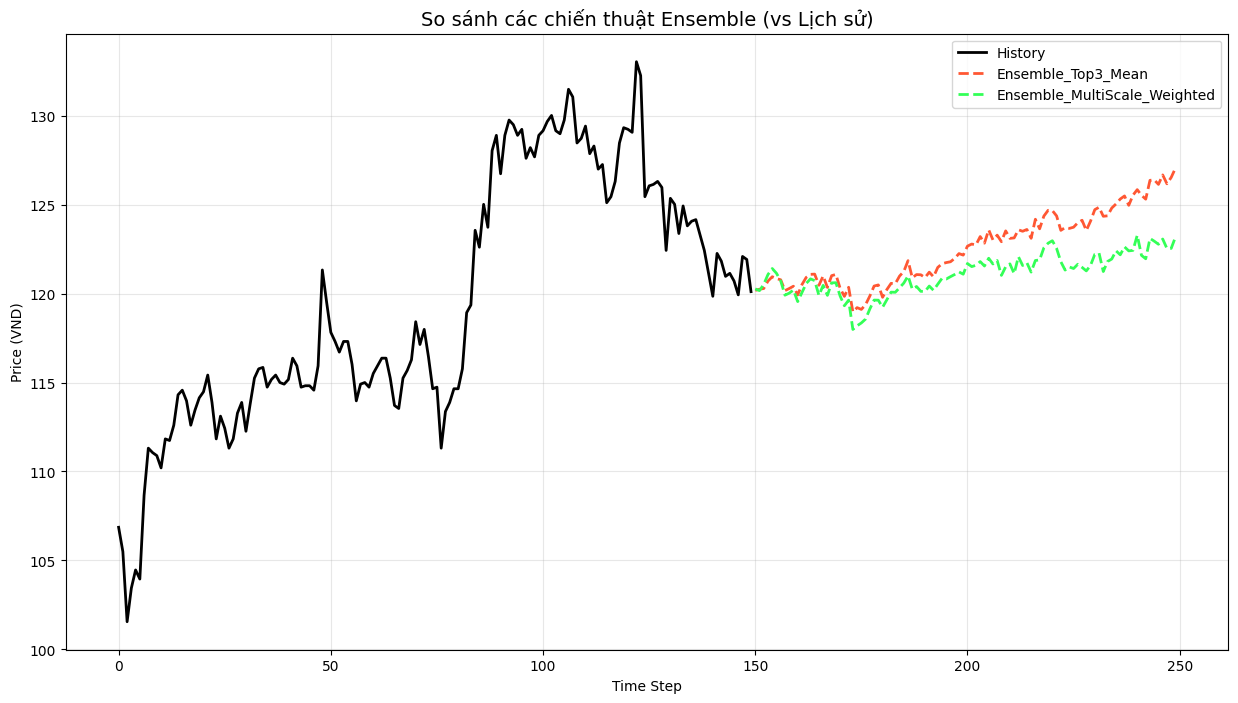

In [ ]:
# --- CELL MỚI: THỬ NGHIỆM CÁC CHIẾN THUẬT ENSEMBLE NÂNG CAO ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

def run_advanced_ensemble():
    submission_dir = Config.SUBMISSION_DIR
    print(f"🔍 Scanning submissions in: {submission_dir}")
    
    # 1. Load tất cả file submission và parse thông tin
    files = glob.glob(os.path.join(submission_dir, "Sub_*.csv"))
    # Loại bỏ các file Ensemble cũ để tránh duplicate
    files = [f for f in files if "Ensemble" not in f]
    
    records = []
    for f in files:
        name = os.path.basename(f)
        parts = name.replace('.csv', '').split('_')
        try:
            # Format: Sub_{Model}_{HMM}_{Win}_{Seq}_{MSE}
            # Lấy MSE (phần tử cuối) và Seq (phần tử kế cuối)
            mse = float(parts[-1].replace('MSE', ''))
            seq = int(parts[-2].replace('Seq', ''))
            records.append({'File': f, 'Name': name, 'Seq': seq, 'MSE': mse})
        except:
            continue
            
    if not records:
        print("❌ Không tìm thấy file submission nào hợp lệ.")
        return

    df_res = pd.DataFrame(records).sort_values('MSE')
    
    print("\n📊 Bảng Xếp Hạng Tạm Thời (Top 5):")
    display(df_res.head(5))

    # 2. Định nghĩa các chiến thuật Ensemble
    strategies = {}
    
    # --- Chiến thuật A: Top 3 Tốt Nhất (Mean) ---
    # (Thường là 3 file Seq60 giống nhau -> Giảm phương sai nhẹ)
    top3_files = df_res.head(3)['File'].tolist()
    strategies['Ensemble_Top3_Mean'] = (top3_files, [1/3, 1/3, 1/3])
    
    # --- Chiến thuật B: Multi-Scale Weighted (Quan trọng nhất) ---
    # Kết hợp cái tốt nhất của Seq 60, Seq 30 và Seq 15
    # Logic: Seq dài nắm Trend chính, Seq ngắn chỉnh sửa biến động cục bộ
    best_seq60 = df_res[df_res['Seq'] == 60].iloc[0]['File'] if not df_res[df_res['Seq'] == 60].empty else None
    best_seq30 = df_res[df_res['Seq'] == 30].iloc[0]['File'] if not df_res[df_res['Seq'] == 30].empty else None
    best_seq15 = df_res[df_res['Seq'] == 15].iloc[0]['File'] if not df_res[df_res['Seq'] == 15].empty else None
    
    multi_scale_files = []
    multi_scale_weights = []
    
    if best_seq60: 
        multi_scale_files.append(best_seq60)
        multi_scale_weights.append(0.5) # Trọng số cao nhất cho Seq60 (vì MSE thấp nhất)
    if best_seq30: 
        multi_scale_files.append(best_seq30)
        multi_scale_weights.append(0.3)
    if best_seq15: 
        multi_scale_files.append(best_seq15)
        multi_scale_weights.append(0.2)
        
    # Chuẩn hóa trọng số về 1
    total_w = sum(multi_scale_weights)
    multi_scale_weights = [w/total_w for w in multi_scale_weights]
    
    if multi_scale_files:
        strategies['Ensemble_MultiScale_Weighted'] = (multi_scale_files, multi_scale_weights)

    # 3. Thực thi và Lưu file
    plt.figure(figsize=(15, 8))
    
    # Vẽ lịch sử (Load lại data train để vẽ)
    try:
        df_hist = pd.read_csv(Config.DATA_PATH)
        # Lấy 150 ngày cuối
        hist_prices = np.expm1(np.log1p(df_hist['close'].iloc[-150:].values)) # Đảm bảo khớp scale
        plt.plot(range(150), hist_prices, label='History', color='black', linewidth=2)
        start_plot = 150
    except:
        start_plot = 0

    print("\n🚀 Đang tạo các file Ensemble...")
    
    colors = ['#FF5733', '#33FF57', '#3357FF']
    for i, (ens_name, (file_list, weights)) in enumerate(strategies.items()):
        print(f"  - {ens_name}: Kết hợp {len(file_list)} models...")
        
        # Load dự báo
        preds_matrix = []
        for f_path in file_list:
            p = pd.read_csv(f_path)['close'].values
            preds_matrix.append(p)
        
        preds_matrix = np.array(preds_matrix)
        
        # Tính trung bình có trọng số
        final_pred = np.average(preds_matrix, axis=0, weights=weights)
        
        # Lưu file
        save_path = os.path.join(submission_dir, f"Sub_{ens_name}.csv")
        pd.DataFrame({'id': range(1, 101), 'close': final_pred}).to_csv(save_path, index=False)
        print(f"    ✅ Saved: {save_path}")
        
        # Vẽ lên biểu đồ
        plt.plot(range(start_plot, start_plot + 100), final_pred, 
                 label=f"{ens_name}", 
                 linestyle='--', linewidth=2, color=colors[i % len(colors)])

    plt.title("So sánh các chiến thuật Ensemble (vs Lịch sử)", fontsize=14)
    plt.xlabel("Time Step")
    plt.ylabel("Price (VND)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Chạy ngay
run_advanced_ensemble()

⚔️ BẮT ĐẦU BACKTEST: Univariate_Linear | Seq_Len=480

🔄 Fold 1/4: Train đến ngày 749 (2023-08-01) -> Dự báo 100 ngày tới
   👉 RMSE: 19.11

🔄 Fold 2/4: Train đến ngày 849 (2023-12-21) -> Dự báo 100 ngày tới
   👉 RMSE: 55.41

🔄 Fold 3/4: Train đến ngày 949 (2024-05-23) -> Dự báo 100 ngày tới
   👉 RMSE: 35.45

🔄 Fold 4/4: Train đến ngày 1049 (2024-10-14) -> Dự báo 100 ngày tới
   👉 RMSE: 28.20

📊 KẾT QUẢ TỔNG HỢP BACKTEST:
   Fold        Date       RMSE
0     1  2023-08-01  19.112373
1     2  2023-12-21  55.411446
2     3  2024-05-23  35.448028
3     4  2024-10-14  28.199701

Trung bình RMSE qua 4 lần thử: 34.54


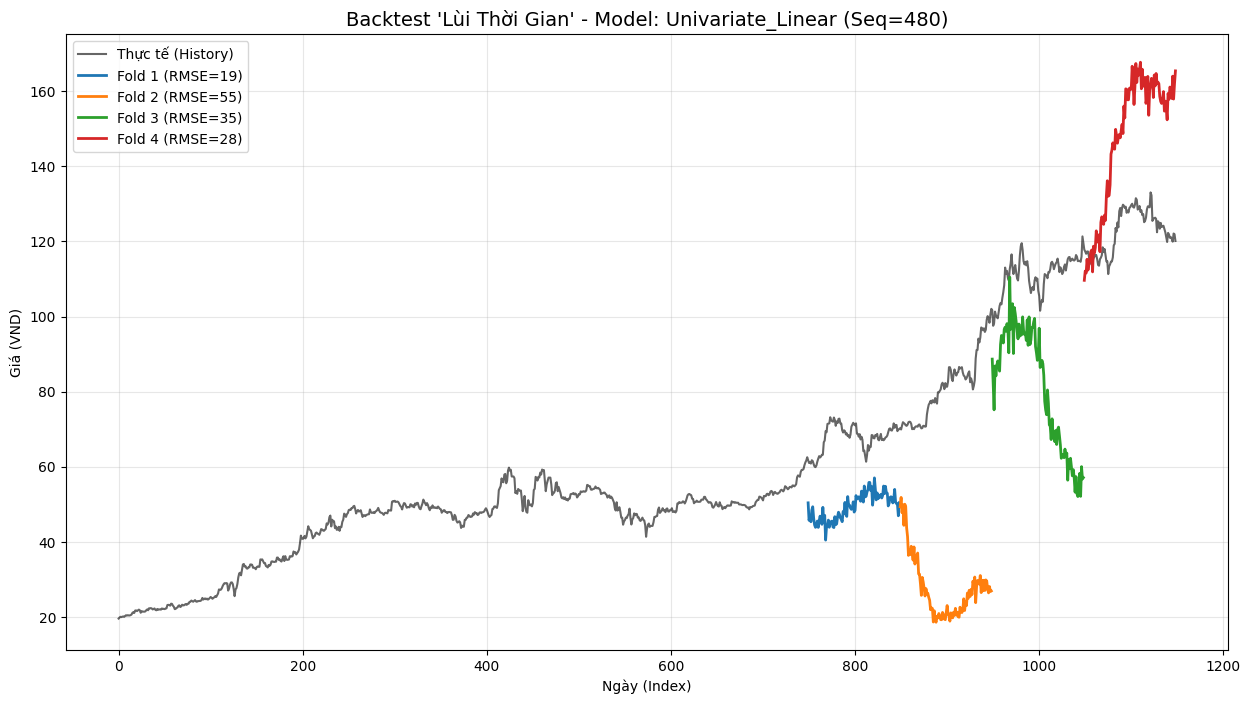

In [ ]:
# --- CELL MỚI: ROLLING BACKTEST (KIỂM TRA ĐỘ BỀN CỦA MODEL) ---
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_squared_error

def run_rolling_backtest(model_name='Univariate_Linear', seq_len=480, folds=4):
    print(f"⚔️ BẮT ĐẦU BACKTEST: {model_name} | Seq_Len={seq_len}")
    
    # 1. Load Data
    dm = DataManager(Config.DATA_PATH)
    df = dm.get_data()
    data_values = df.values # Toàn bộ dữ liệu (bao gồm cả các cột features)
    
    # Target column index (Close Log)
    target_idx = df.columns.get_loc('close_log')
    # Feature columns indices
    feature_cols = ['close_log', 'volume_log', 'HL_Spread', 'OC_Spread']
    feature_idxs = [df.columns.get_loc(c) for c in feature_cols]
    
    # 2. Xác định các điểm cắt (Cutoffs)
    # Ta sẽ test lùi từ hiện tại về quá khứ
    # Mỗi fold cách nhau 100 ngày (bằng Pred_Len)
    total_len = len(df)
    pred_len = 100
    
    cutoffs = []
    for i in range(folds):
        # Ví dụ: 1149 -> 1049 -> 949 -> 849
        cut = total_len - (i + 1) * pred_len
        if cut > seq_len + 50: # Đảm bảo đủ data để train
            cutoffs.append(cut)
    
    cutoffs = sorted(cutoffs) # Sắp xếp từ quá khứ -> hiện tại
    results = []
    
    plt.figure(figsize=(15, 8))
    
    # Vẽ giá thực tế (History)
    # Convert log close to real price for plotting
    real_close = np.expm1(df['close_log'].values)
    plt.plot(range(total_len), real_close, label='Thực tế (History)', color='black', linewidth=1.5, alpha=0.6)
    
    # 3. Chạy vòng lặp Backtest
    for i, cutoff in enumerate(cutoffs):
        print(f"\n🔄 Fold {i+1}/{folds}: Train đến ngày {cutoff} ({df['time'].iloc[cutoff].date()}) -> Dự báo 100 ngày tới")
        
        # A. Chia dữ liệu tại điểm cắt
        train_data = data_values[:cutoff]
        test_data = data_values[cutoff : cutoff + pred_len]
        
        # B. Tạo Sliding Window cho Train
        X_train, y_train = create_sliding_window(train_data, seq_len, pred_len, target_idx, feature_idxs)
        
        # C. Train Model
        # Khởi tạo lại model mới tinh (Reset weights)
        seed_everything(42) 
        model = ModelFactory.create_model(model_name, seq_len, pred_len, len(feature_idxs)).to(device)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        
        # Train nhanh (không cần validation cầu kỳ vì đang test logic)
        model.train()
        train_dataset = TimeSeriesDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
        
        for epoch in range(100): # Train 100 epochs cho nhanh
            for bx, by in train_loader:
                bx, by = bx.to(device), by.to(device)
                optimizer.zero_grad()
                loss = criterion(model(bx), by)
                loss.backward()
                optimizer.step()
                
        # D. Dự báo (Forecast)
        # Lấy chuỗi seq_len cuối cùng của tập train để dự báo tương lai
        last_seq = train_data[-seq_len:, feature_idxs]
        last_seq_tensor = torch.tensor(last_seq.astype(np.float32)).unsqueeze(0).to(device)
        
        model.eval()
        with torch.no_grad():
            pred_log = model(last_seq_tensor).cpu().numpy().flatten()
        
        pred_price = np.expm1(pred_log)
        
        # E. So sánh với thực tế (Ground Truth)
        actual_log = test_data[:, target_idx]
        actual_price = np.expm1(actual_log.astype(float))
        
        # Tính lỗi
        mse = mean_squared_error(actual_price, pred_price)
        rmse = np.sqrt(mse)
        
        results.append({
            'Fold': i+1,
            'Date': df['time'].iloc[cutoff].date(),
            'RMSE': rmse
        })
        print(f"   👉 RMSE: {rmse:.2f}")
        
        # F. Vẽ lên biểu đồ
        x_range = range(cutoff, cutoff + pred_len)
        plt.plot(x_range, pred_price, label=f'Fold {i+1} (RMSE={rmse:.0f})', linewidth=2)

    # 4. Tổng kết
    print("\n📊 KẾT QUẢ TỔNG HỢP BACKTEST:")
    res_df = pd.DataFrame(results)
    print(res_df)
    print(f"\nTrung bình RMSE qua {folds} lần thử: {res_df['RMSE'].mean():.2f}")

    plt.title(f"Backtest 'Lùi Thời Gian' - Model: {model_name} (Seq={seq_len})", fontsize=14)
    plt.xlabel("Ngày (Index)")
    plt.ylabel("Giá (VND)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Chạy test với "Kẻ Ngốc Kiên Định" Seq480
run_rolling_backtest(model_name='Univariate_Linear', seq_len=480, folds=4)